<a href="https://colab.research.google.com/github/tgieruc/Heritage-in-the-digital-age/blob/main/demo_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Heritage in the digital age</h1>
<h3 align="center"><em>A Step-by-Step Guide to Augmenting Digitized Historical Images </em></h3>
<h4 align="center"><i>Semester Project @ CVlab &amp; EPFL+ECAL Lab </i></h4>

<h4 align="center"><b>Demo of the pipeline</b></h4>


Welcome to this demo of the pipeline. First, we have a few libraries to install, and the github repository to clone, with its submodule

In [9]:
!pip install --quiet --upgrade pandas transformers yacs
!pip install transformers[sentencepiece] 
!pip install -q -U --no-cache-dir gdown --pre

In [ ]:
!git clone --recurse-submodules https://github.com/tgieruc/Heritage-in-the-digital-age
%cd Heritage-in-the-digital-age

In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

### Presentation of the demo dataset
Let's look at our demo dataset. It consists on 3 files:
* 'demo/demo_pipeline_input.pkl': a pickled pandas dataframe with the raw data, with only one entry
* 'demo/img/street_cats_324w.jpg': a picture of a cats in the street, with a width of 324 pixels
* 'demo/img/street_cats_2975h.jpg': a picture of a cats in the street, with a height of 2975 pixels

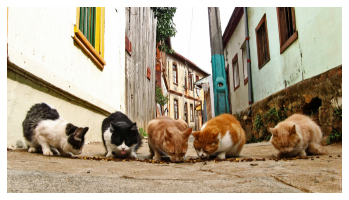

In [170]:
plt.imshow(plt.imread('demo/img/street_cats_2975h.jpg'))
plt.axis('off');

## 1: Translation of the title from French to English
Let's first check the title of the image:

In [177]:
print(f'The title in French: {pd.read_pickle("demo/demo_pipeline_input.pkl").iloc[0]["title"]}')
pd.read_pickle('demo/demo_pipeline_input.pkl')

The title in French: Des chats à la rue Augustin, Fribourg


,bcu_id,title,caption
0,street_cats,"Des chats à la rue Augustin, Fribourg",cats eating food in the street


We can execute the translation script, by indicating the raw dataframe, the column to translate, the output file and the device on which the model will run.

In [178]:
!python pipeline/1_translate.py --input_file demo/demo_pipeline_input.pkl --column title --output_file demo/1_translation.pkl --device cuda

  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100% 1/1 [00:02<00:00,  2.18s/it]


We have now a new dataframe, with the translated column, indicated by the suffix ```_en```

In [179]:
print(f'The translated title: {pd.read_pickle("demo/1_translation.pkl").iloc[0]["title_en"]}')
pd.read_pickle('demo/1_translation.pkl')

The translated title: Cats on Augustin Street, Fribourg


,bcu_id,title,caption,title_en
0,street_cats,"Des chats à la rue Augustin, Fribourg",cats eating food in the street,"Cats on Augustin Street, Fribourg"


## 2: The preprocessing 
We will preprocess the captions and titles for preparing them for the Phrase Grounding model. We will also link the image filenames to the dataframe.

This is done by excuting the ```2_preprocessing.py``` script and indicating the input dataframe, the column containing the ids related to the filename of the images, the image directory, the output file, the wanted quality of the images and the columns to preprocess

In [180]:
!python pipeline/2_preprocessing.py --input_file demo/1_translation.pkl --id_column bcu_id --image_directory demo/img --output_file demo/2_preprocessing.pkl --quality 324w --columns_to_preprocess caption title_en

We can now look at all the changes in the output dataframe:

In [181]:
p2_preprocessing = pd.read_pickle('demo/2_preprocessing.pkl')
print('The new information:')
print(f' - The preprocessed caption: {p2_preprocessing.iloc[0]["caption_preprocessed"]}')
print(f' - The preprocessed title: {p2_preprocessing.iloc[0]["title_en_preprocessed"]}')
print(f' - The image path: {p2_preprocessing.iloc[0]["filename"]}')
p2_preprocessing

The new information:
 - The preprocessed caption: cats eating food in the street
 - The preprocessed title: cats on augustin street, 
 - The image path: street_cats_324w.jpg


,bcu_id,title,caption,title_en,filename,caption_preprocessed,title_en_preprocessed
0,street_cats,"Des chats à la rue Augustin, Fribourg",cats eating food in the street,"Cats on Augustin Street, Fribourg",street_cats_324w.jpg,cats eating food in the street,"cats on augustin street,"


## 3: The Phrase Grounding!
Here, we will run 4 inferences: 
* MDETR + caption
* MDETR + title
* GLIP + caption
* GLIP + title

We will store the intermediate results in a temporary DataFrame

> As this take some time, and requires many new dependencies, it is possible to skip this part in the demo and use the provided dataframe post-phrase grounding. If so, directly go [here](https://colab.research.google.com/github/tgieruc/Heritage-in-the-digital-age/blob/main/demo_pipeline.ipynb#scrollTo=RL4KjesN0AXm&line=8&uniqifier=1=)  

### MDETR
MDETR requires a specific version of timm and transformers

In [ ]:
!pip install timm==0.4.5 transformers==4.5.1

In [183]:
!python pipeline/3_MDETR_inference.py --input_file demo/2_preprocessing.pkl --output_file temp.pkl --expression_column caption_preprocessed --inference_column MDETR_caption --image_directory demo/img 

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100% 1/1 [00:00<00:00,  2.61it/s]


In [184]:
!python pipeline/3_MDETR_inference.py --input_file temp.pkl --output_file temp.pkl --expression_column title_en_preprocessed --inference_column MDETR_title --image_directory demo/img 

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100% 1/1 [00:00<00:00,  3.60it/s]


We have the following results:

In [197]:
pd.read_pickle('temp.pkl').loc[0,['MDETR_caption', 'MDETR_title']].apply(lambda x: (f'conf: {x[0]}, labels: {x[2]}, bbox: {x[1]}'))

MDETR_caption    conf: tensor([0.9420, 0.9629, 0.7233, 0.7049, ...
MDETR_title      conf: tensor([0.9712, 0.9470, 0.9707, 0.9808, ...
Name: 0, dtype: object

### GLIP 
GLIP is a bit more complex to get working. It needs a specific version of CUDA, several dependencies and a huge weight file. It can take up to 20 minutes. 

> If you do not want to wait this long, you can directly go to the visualization of results [here](https://colab.research.google.com/github/tgieruc/Heritage-in-the-digital-age/blob/main/demo_pipeline.ipynb#scrollTo=RL4KjesN0AXm&line=8&uniqifier=1=)

In [ ]:
# Install CUDA 10.2; newer versions of CUDA may fail
!apt-get update -y
!apt-get --purge remove "*cublas*" "cuda*" "nsight*" 
!nvcc --version

!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/10.2/Prod/local_installers/cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01_1.0-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01_1.0-1_amd64.deb
!apt-key add /var/cuda-repo-10-2-local-10.2.89-440.33.01/7fa2af80.pub
!apt-get update
!apt-get -y install cuda

In [ ]:
%cd  pipeline/src/GLIP
! git checkout c663d9db8a503e04c6b76cd2e14152bab775d28a
! pip install torch==1.9.0 torchvision  torchaudio
! pip install einops shapely timm yacs tensorboardX ftfy prettytable pymongo
! pip install transformers
! python setup.py build develop --user
%cd ../../..

In [19]:
!wget https://penzhanwu2bbs.blob.core.windows.net/data/GLIPv1_Open/models/glip_large_model.pth 

--2023-01-09 16:30:09--  https://penzhanwu2bbs.blob.core.windows.net/data/GLIPv1_Open/models/glip_large_model.pth
Resolving penzhanwu2bbs.blob.core.windows.net (penzhanwu2bbs.blob.core.windows.net)... 20.60.68.132
Connecting to penzhanwu2bbs.blob.core.windows.net (penzhanwu2bbs.blob.core.windows.net)|20.60.68.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896153761 (6.4G) [application/octet-stream]
Saving to: ‘glip_large_model.pth’

glip_large_model.pt 100%[===================>]   6.42G  5.99MB/s    in 18m 7s  

2023-01-09 16:48:17 (6.05 MB/s) - ‘glip_large_model.pth’ saved [6896153761/6896153761]



In [ ]:
!python pipeline/3_GLIP_inference.py --input_file temp.pkl --output_file temp.pkl --expression_column caption_preprocessed --inference_column GLIP_caption --image_directory demo/img --config_file pipeline/src/GLIP/configs/pretrain/glip_Swin_L.yaml --weights_file glip_large_model.pth 

In [ ]:
!python pipeline/3_GLIP_inference.py --input_file temp.pkl --output_file demo/3_phrase_grounding.pkl --expression_column title_en_preprocessed --inference_column GLIP_title --image_directory demo/img --config_file pipeline/src/GLIP/configs/pretrain/glip_Swin_L.yaml --weights_file glip_large_model.pth 

In [200]:
pd.read_pickle('demo/3_phrase_grounding.pkl')[['MDETR_caption', 'MDETR_title', 'GLIP_caption', 'GLIP_title']]

,MDETR_caption,MDETR_title,GLIP_caption,GLIP_title
0,"([tensor(0.9420), tensor(0.9629), tensor(0.723...","([tensor(0.9712), tensor(0.9470), tensor(0.970...","[[tensor(0.8901), tensor(0.8686), tensor(0.838...","[[tensor(0.9052), tensor(0.8908), tensor(0.855..."


 ### Let's visualize the resuls!
 Some helper functions

In [156]:
from matplotlib.patches import Polygon
from skimage.measure import find_contours
from itertools import compress
import numpy as np

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def get_color(label, set_label):
    for i, elem in enumerate(set_label):
        if elem == label:
            return i
    return 0


def plot_results(ax, pil_img, results, masks=None, conf=0.7):
    if len(results) == 0:
        return ax
    np_image = np.array(pil_img)
    colors = COLORS * 100
    keep = results[0] > conf
    scores = results[0][keep]
    boxes = results[1][keep]
    labels = list(compress(results[2], keep))
    set_label = set(labels)

    if masks is None:
        masks = [None for _ in range(len(scores))]
    else:
        masks = masks[results[0] > conf]

    for s, (xmin, ymin, xmax, ymax), l, mask in zip(scores, boxes.tolist(), labels, masks):
        c = colors[get_color(l, set_label)]
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=1))
        text = f'{l}: {s:0.2f}'
        ax.text(int(xmin), int(ymin), text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
            continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=c)
            ax.add_patch(p)

    ax.imshow(np_image)

    return ax

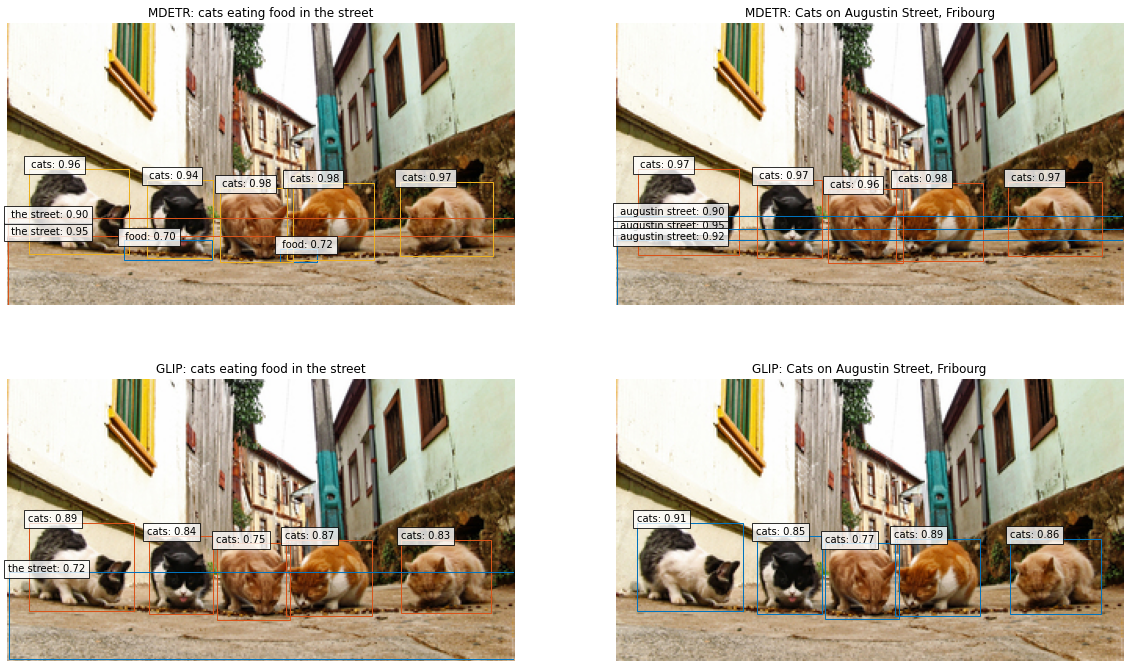

In [215]:
results = pd.read_pickle('demo/3_phrase_grounding.pkl').iloc[0]
img = plt.imread('demo/img/' + results['filename'])
fig, ax = plt.subplots(2,2,figsize=(20,12))
for i, (model, expression) in enumerate(zip(*[['MDETR', 'MDETR', 'GLIP', 'GLIP'],['caption', 'title', 'caption', 'title']])):
  j,k = i // 2, i % 2
  ax[j,k] = plot_results(ax[j,k], img, results[f'{model}_{expression}'], masks=None, conf=0)
  ax[j,k].title.set_text(f"{model}: {results['caption'] if expression=='caption' else results['title_en']}")
  ax[j,k].set_xticks([])
  ax[j,k].set_yticks([])
  ax[j,k].axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.show()

## 4: Postprocessing
As we can see, for both MDETR inferences, there are several detection per objects. In order to fix this, we apply the NMS to the results. To compare, we can look at the number of detection before and after applying the NMS

In [202]:
print(f'MDETR-caption: {len(results["MDETR_caption"][0])}, MDETR-title: {len(results["MDETR_title"][0])}, GLIP-caption: {len(results["GLIP_caption"][0])}, GLIP-title: {len(results["GLIP_title"][0])}')

MDETR-caption: 9, MDETR-title: 8, GLIP-caption: 6, GLIP-title: 5


In [203]:
!python pipeline/4_apply_nms.py --input_file demo/3_phrase_grounding.pkl --output_file demo/4_postprocess.pkl --columns_to_process GLIP_caption GLIP_title MDETR_caption MDETR_title

100% 1/1 [00:00<00:00, 25.34it/s]
100% 1/1 [00:00<00:00, 776.72it/s]
100% 1/1 [00:00<00:00, 560.74it/s]
100% 1/1 [00:00<00:00, 706.23it/s]


In [204]:
post_nms = pd.read_pickle('demo/4_postprocess.pkl').loc[0]
print(f'MDETR-caption: {len(post_nms["MDETR_caption"][0])}, MDETR-title: {len(post_nms["MDETR_title"][0])}, GLIP-caption: {len(post_nms["GLIP_caption"][0])}, GLIP-title: {len(post_nms["GLIP_title"][0])}')

MDETR-caption: 8, MDETR-title: 6, GLIP-caption: 6, GLIP-title: 5


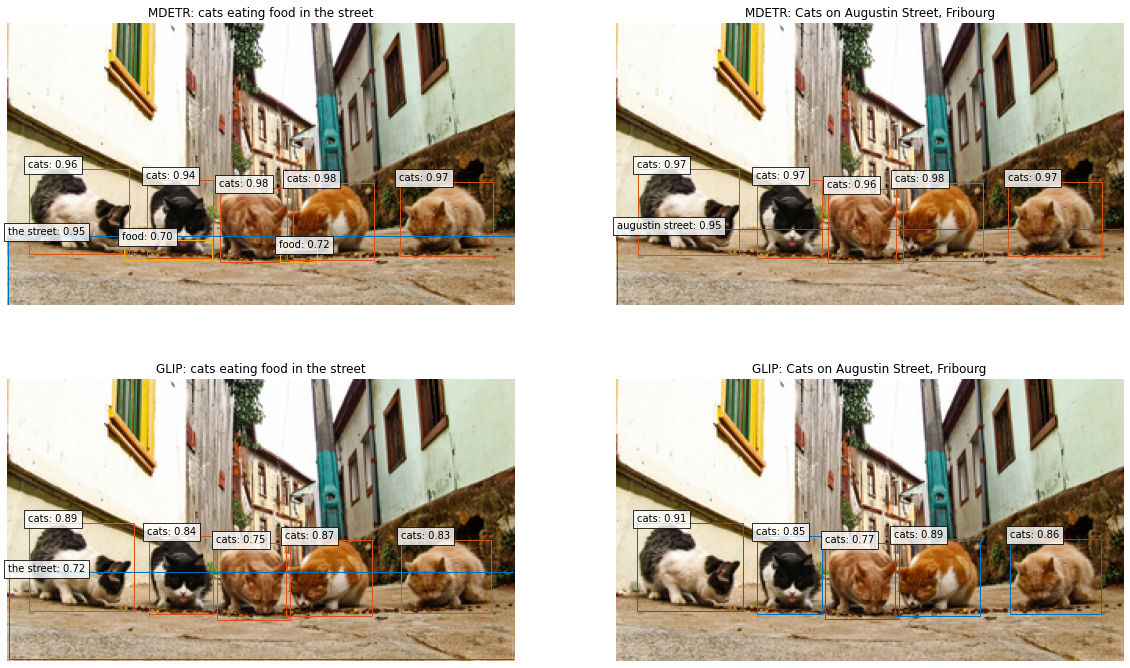

In [220]:
postprocess = pd.read_pickle('demo/4_postprocess.pkl')
results = postprocess.iloc[0]

fig, ax = plt.subplots(2,2,figsize=(20,12))
for i, (model, expression) in enumerate(zip(*[['MDETR', 'MDETR', 'GLIP', 'GLIP'],['caption', 'title', 'caption', 'title']])):
  j,k = i // 2, i % 2
  ax[j,k] = plot_results(ax[j,k], img, results[f'{model}_{expression}'], masks=None, conf=0)
  ax[j,k].title.set_text(f"{model}: {results['caption'] if expression=='caption' else results['title_en']}")
  ax[j,k].set_xticks([])
  ax[j,k].set_yticks([])
  ax[j,k].axis('off')
fig.patch.set_facecolor('xkcd:white')
plt.show()

## 5: Selection of the best inference
There are two ways of selecting the best inference:
* Manually, with ```5_manual_selection_best_phrase_grounding.py```. A GUI allows the user to select the best inference, using the numpad keys.
* Automatically, with ```5_automatic_selection_best_phrase_grounding.py```, a script that uses a NLP model trained to rank expression. 

In this demo, as we have only one image, we will directly select the best inference. 

Personally, I prefer the inference from MDETR with the caption.

In [222]:
postprocess['selection'] = 'MDETR_caption'
postprocess.to_pickle('demo/5_selection.pkl')
postprocess.iloc[0]

bcu_id                                                         street_cats
title                                Des chats à la rue Augustin, Fribourg
caption                                     cats eating food in the street
title_en                                 Cats on Augustin Street, Fribourg
filename                                              street_cats_324w.jpg
caption_preprocessed                        cats eating food in the street
title_en_preprocessed                            cats on augustin street, 
MDETR_caption            [[tensor(0.9816), tensor(0.9756), tensor(0.971...
MDETR_title              [[tensor(0.9808), tensor(0.9718), tensor(0.971...
GLIP_caption             [[tensor(0.8901), tensor(0.8686), tensor(0.838...
GLIP_title               [[tensor(0.9052), tensor(0.8908), tensor(0.855...
selection                                                    MDETR_caption
Name: 0, dtype: object

## 6: Segmentation

Let's first download the model

In [228]:
!gdown 1OWH7arM-qllbCJwqkMVy9NKWHB398iol

Downloading...
From: https://drive.google.com/uc?id=1OWH7arM-qllbCJwqkMVy9NKWHB398iol
To: /content/Heritage-in-the-digital-age/model_segmentation.pth
100% 97.9M/97.9M [00:03<00:00, 29.8MB/s]


We also have to upgrade timm, but no need to restart the runtime

In [260]:
!pip install --quiet --upgrade timm

In [232]:
!python pipeline/6_segmentation.py --input_file demo/5_selection.pkl --output_dir demo/7_segmentation_results --image_dir demo/img --selection_column selection --save_fig --save_segmentation_pickle --model_path model_segmentation.pth --save_colored_text_array --save_colored_text_html --device cuda

  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100% 1/1 [00:00<00:00,  1.97it/s]


We can now visualize the result!

In [261]:
post_segmentation = pd.read_pickle('demo/results/6_segmentation_output.pkl')
post_segmentation.iloc[0]

bcu_id                                                         street_cats
title                                Des chats à la rue Augustin, Fribourg
caption                                     cats eating food in the street
title_en                                 Cats on Augustin Street, Fribourg
filename                                              street_cats_324w.jpg
caption_preprocessed                        cats eating food in the street
title_en_preprocessed                            cats on augustin street, 
MDETR_caption            [[tensor(0.9816), tensor(0.9756), tensor(0.971...
MDETR_title              [[tensor(0.9808), tensor(0.9718), tensor(0.971...
GLIP_caption             [[tensor(0.8901), tensor(0.8686), tensor(0.838...
GLIP_title               [[tensor(0.9052), tensor(0.8908), tensor(0.855...
selection                                                    MDETR_caption
segmentation_output      {'colored_text': {'text': ['cats', ' eating ',...
colored_text             


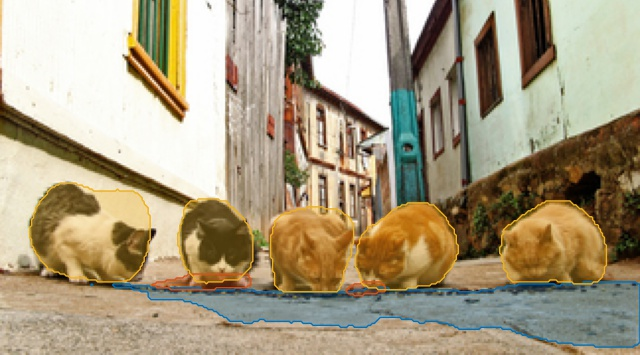

In [259]:
import IPython, base64
html_text = post_segmentation.loc[0, 'colored_text_html']
result_fig = 'demo/results/street_cats_324w.jpg'

encoded = base64.b64encode(open(result_fig, "rb").read())
img = f"data:image/png;base64,{encoded.decode('utf-8')}"

IPython.display.HTML(f'<h3 align="center">{html_text}</h3>' + f'<p style="text-align:center;"><img align="center" src={img} alt="" width="600" height="400">')
